In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.stats import skew, kurtosis
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split

#### Loading the data into dataframe

In [59]:
train_data = pd.read_csv("train.csv", header=None)
test_data = pd.read_csv("test.csv", header=None)


#dividing into label and timeseries
X_training = train_data.iloc[: , 1:].values
y_training = train_data.iloc[:, 0].values

X_train, X_test_evaluation, y_train, y_test_evaluation = train_test_split(X_training, y_training, random_state=42)


print("X train shape: ", X_train.shape)
print("y train shape: ", y_train.shape)
print("X test shape: ", X_test_evaluation.shape)
print("y test shape: ", y_test_evaluation.shape)
print("The classes in this dataset: ", np.unique(y_train))

X train shape:  (3749, 178)
y train shape:  (3749,)
X test shape:  (1250, 178)
y test shape:  (1250,)
The classes in this dataset:  [0 1 2 3 4]


### Understanding the dataset

* Each row is one signal instance
* The first column in the train data is the class label
* Usually sleep soring system divide the recording of EEG into 30 seconds intervals called epochs.

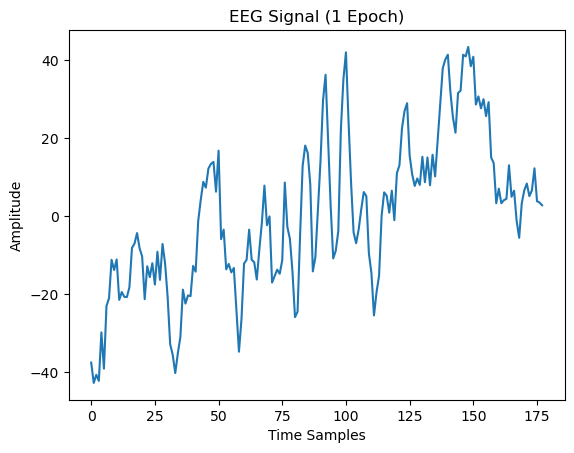

In [60]:
signal = X_train[0]

# Plot it
plt.plot(signal)
plt.title("EEG Signal (1 Epoch)")
plt.xlabel("Time Samples")
plt.ylabel("Amplitude")
plt.show()

### Taking the data from the time domain to the frequency domain

To be able to train machine learning models on this data that is a time series, we should have a predefined vector of features with a fixed length. 

Many approaches exist to do so, the approach we are taking is the frequency domain analysis and this could be done since the sleep cycle exhibits the spectral characteristics.



| Label  | Scientific Term        | Key EEG Features                                                     |
| ----------- | ---------------------- | -------------------------------------------------------------------- |
| **Wake**    | Wakefulness            | High alpha and beta power, low delta.                                |
| **E1 (N1)** | Light sleep stage 1    | Theta power rises, alpha reduces.                                    |
| **E2 (N2)** | Light sleep stage 2    | Theta + sleep spindles (sigma).                                      |
| **E3 (N3)** | Deep sleep (slow-wave) | Dominated by delta power.                                            |
| **REM**     | Dream sleep            | Mixed frequency (theta, some beta), low muscle tone, resembles wake. |


#### 1. Applying the Welch's method:     

This method does the following: 
* Split the signal into non overlapping segments.       
* Apply the Fast Fourier Transform (FFT) for each segment to take the data from the time domain to the frequency domain, and compute the power.       
* Average the power results over each segment and smooth out noise which means it computes the Power Density Function (PSD).     


***Note:***    

Based on the litterature the EEG Frequency the bands are as follows:  

- Delta: from 0.5 Hz to 4 Hz    -->  Deep sleep
- Theta: from 4 Hz to 8 Hz  -->  Light sleep   
- Alpha: from 8 Hz to 12 Hz     -->  Relaxed    
- Sigma: from 12 Hz to 16 H     -->  Sleep spind (bursts of neural oscillatory activity)    
- Beta: from 16 Hz to 30 Hz     -->  Thinking/ alert    
- Gamma: from 30 Hz to 45 H     -->  High level cognitive processes       

In [61]:
bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'sigma': (12, 16),
    'beta': (16, 30),
    'gamma': (30, 45)
}

In [62]:
import numpy as np
from scipy.signal import welch
from scipy.stats import skew, kurtosis, entropy
import pywt
import antropy as ant  # For permutation entropy and fractal dimension

sampling_freq = 100  # Hz

def extract_features(signal):
    freq, power_spectral_density = welch(signal, fs=sampling_freq, nperseg=min(len(signal), 256))
    total_power = np.trapz(power_spectral_density, freq)

    features = {}

    # Band powers and relative powers
    for band_name, (low, high) in bands.items():
        idx_band = np.logical_and(freq >= low, freq <= high)
        band_power = np.trapz(power_spectral_density[idx_band], freq[idx_band])
        features[f"{band_name}_power"] = band_power  # Absolute power in {band_name} band
        features[f"relative_{band_name}"] = band_power / total_power if total_power > 0 else 0  # Relative power in {band_name} band

    # Ratios between bands
    features["delta_theta_ratio"] = features["delta_power"] / (features["theta_power"] + 1e-10)  # Delta-to-theta power ratio
    features["theta_alpha_ratio"] = features["theta_power"] / (features["alpha_power"] + 1e-10)  # Theta-to-alpha power ratio

    # Spectral edge frequency (90%)
    cumulative_power = np.cumsum(power_spectral_density)
    spectral_edge_frequency = freq[np.where(cumulative_power >= 0.9 * cumulative_power[-1])[0][0]]
    features["spectral_edge"] = spectral_edge_frequency  # Spectral edge frequency (frequency below which 90% of power is contained)

    # Sigma band power = Spindle density
    features["spindle_density"] = features["sigma_power"]  # Spindle density (power in sigma band)

    # Spectral entropy
    psd_norm = power_spectral_density / np.sum(power_spectral_density)
    spectral_entropy = -np.sum(np.log2(psd_norm + 1e-10) * psd_norm)
    features["spectral_entropy"] = spectral_entropy  # Spectral entropy (irregularity in frequency domain)

    # Spectral flux
    spectral_flux = np.sum(np.diff(power_spectral_density) ** 2)
    features["spectral_flux"] = spectral_flux  # Spectral flux (change in power spectrum between adjacent frequencies)

    # Peak frequency
    peak_frequency = freq[np.argmax(power_spectral_density)]
    features["peak_frequency"] = peak_frequency  # Peak frequency (dominant frequency in the signal)

    # Peak-to-peak amplitude
    peak_to_peak = np.max(signal) - np.min(signal)
    features["peak_to_peak"] = peak_to_peak  # Peak-to-peak amplitude (max - min signal value)

    # Time domain statistical features
    features["mean"] = np.mean(signal)  # Mean value of signal
    features["std"] = np.std(signal)  # Standard deviation of signal
    features["var"] = np.var(signal)  # Variance of signal
    features["median"] = np.median(signal)  # Median value of signal
    features["min"] = np.min(signal)  # Minimum value of signal
    features["max"] = np.max(signal)  # Maximum value of signal
    features["skewness"] = skew(signal)  # Skewness (asymmetry) of signal
    features["kurtosis"] = kurtosis(signal)  # Kurtosis (peakedness) of signal

    # Spectral edge frequencies (50% and 95%)
    total_cum_power = cumulative_power[-1]
    features["spectral_edge_50"] = freq[np.where(cumulative_power >= 0.50 * total_cum_power)[0][0]]  # Spectral edge frequency at 50% power
    features["spectral_edge_95"] = freq[np.where(cumulative_power >= 0.95 * total_cum_power)[0][0]]  # Spectral edge frequency at 95% power

    # Entropy in time domain
    hist_counts, _ = np.histogram(signal, bins=20)
    features["sample_entropy"] = entropy(hist_counts + 1e-10)  # Sample entropy (irregularity in time domain)

    # Hjorth parameters
    diff_1 = np.diff(signal)
    diff_2 = np.diff(diff_1)

    activity = np.var(signal)
    mobility = np.sqrt(np.var(diff_1) / activity) if activity > 0 else 0
    complexity = np.sqrt(np.var(diff_2) / np.var(diff_1)) if np.var(diff_1) > 0 else 0

    features["hjorth_activity"] = activity  # Hjorth activity (signal variance)
    features["hjorth_mobility"] = mobility  # Hjorth mobility (mean frequency)
    features["hjorth_complexity"] = complexity  # Hjorth complexity (frequency variation)

    # Zero-crossing rate
    zero_crossings = np.sum(np.diff(np.signbit(signal).astype(int)) != 0)
    features["zero_crossing_rate"] = zero_crossings  # Zero-crossing rate (number of times signal crosses zero)

    # Wavelet features (db4, level 4 decomposition)
    coeffs = pywt.wavedec(signal, 'db4', level=4)
    for i, coeff in enumerate(coeffs):
        features[f"wavelet_L{i}_mean"] = np.mean(coeff)  # Mean of wavelet level {i} coefficients
        features[f"wavelet_L{i}_std"] = np.std(coeff)  # Std of wavelet level {i} coefficients
        features[f"wavelet_L{i}_max"] = np.max(coeff)  # Max of wavelet level {i} coefficients
        features[f"wavelet_L{i}_min"] = np.min(coeff)  # Min of wavelet level {i} coefficients

    # === Added features specifically for sleep cycle classification ===

    # Root Mean Square (RMS)
    features["rms"] = np.sqrt(np.mean(signal ** 2))  # RMS (energy measure, helps detect sleep depth)

    # Signal Energy
    features["energy"] = np.sum(signal ** 2)  # Signal energy (sum of squares)

    # Line Length
    features["line_length"] = np.sum(np.abs(np.diff(signal)))  # Line length (sum of absolute differences, sensitive to transitions)

   
    # Permutation Entropy
    features["permutation_entropy"] = ant.perm_entropy(signal, normalize=True)  # Permutation entropy (irregularity, good sleep-wake separator)

    return features


Extracting the features for the train set

In [63]:
feature_list = []
for signal in np.array(X_train):
    features = extract_features(signal)
    feature_list.append(features)

X_train_features = feature_list
print(X_train_features)

[{'delta_power': 92.79816640466093, 'relative_delta': 0.32700465209430524, 'theta_power': 23.080238202523162, 'relative_theta': 0.08133075852768899, 'alpha_power': 10.695312288674604, 'relative_alpha': 0.03768842650130556, 'sigma_power': 83.67138479110112, 'relative_sigma': 0.2948434557914769, 'beta_power': 3.512986065691687, 'relative_beta': 0.012379153928691782, 'gamma_power': 4.144304322769932, 'relative_gamma': 0.014603810029292123, 'delta_theta_ratio': 4.0206762854862585, 'theta_alpha_ratio': 2.157977025761773, 'spectral_edge': 13.483146067415731, 'spindle_density': 83.67138479110112, 'spectral_entropy': 3.967268466640004, 'spectral_flux': 30862.179811386417, 'peak_frequency': 0.5617977528089888, 'peak_to_peak': 86.15287000000001, 'mean': 0.3218559185112352, 'std': 19.806631564365862, 'var': 392.30265392653405, 'median': 0.0434676475, 'min': -42.728695, 'max': 43.424175, 'skewness': 0.14861203140238027, 'kurtosis': -0.44425418090991453, 'spectral_edge_50': 5.056179775280899, 'spec

Extracting the features for the test set

In [64]:
feature_list = []
for signal in np.array(X_test_evaluation):
    features = extract_features(signal)
    feature_list.append(features)

X_test_evaluation_features = feature_list

In [65]:
# feature_list = []
# for signal in np.array(X_test):
#     features = extract_features(signal)
#     feature_list.append(features)

# X_test_features = feature_list

### Feature selection

This step is a crutial step, because of the number of features that is high the model can suffer from the curse of dimensionality   
By selecting the features, we reduce the model complexity and reduce the overfitting    

The algorithm chosen for this step is: **Mutual information**  
This aims to measure how much information a feature gives about the target.

In [66]:
X_train_features[0]

{'delta_power': 92.79816640466093,
 'relative_delta': 0.32700465209430524,
 'theta_power': 23.080238202523162,
 'relative_theta': 0.08133075852768899,
 'alpha_power': 10.695312288674604,
 'relative_alpha': 0.03768842650130556,
 'sigma_power': 83.67138479110112,
 'relative_sigma': 0.2948434557914769,
 'beta_power': 3.512986065691687,
 'relative_beta': 0.012379153928691782,
 'gamma_power': 4.144304322769932,
 'relative_gamma': 0.014603810029292123,
 'delta_theta_ratio': 4.0206762854862585,
 'theta_alpha_ratio': 2.157977025761773,
 'spectral_edge': 13.483146067415731,
 'spindle_density': 83.67138479110112,
 'spectral_entropy': 3.967268466640004,
 'spectral_flux': 30862.179811386417,
 'peak_frequency': 0.5617977528089888,
 'peak_to_peak': 86.15287000000001,
 'mean': 0.3218559185112352,
 'std': 19.806631564365862,
 'var': 392.30265392653405,
 'median': 0.0434676475,
 'min': -42.728695,
 'max': 43.424175,
 'skewness': 0.14861203140238027,
 'kurtosis': -0.44425418090991453,
 'spectral_edge_50

In [67]:
X_train_features_df = pd.DataFrame(X_train_features)
X_test_evaluation_features_df = pd.DataFrame(X_test_evaluation_features)

In [68]:
selector = SelectKBest(score_func=mutual_info_classif, k='all')
selector.fit(X_train_features_df, y_train)

scores = selector.scores_
feature_scores = pd.DataFrame({'Feature': X_train_features_df.columns, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

print(feature_scores)

                Feature     Score
32      hjorth_mobility  0.365943
31      hjorth_activity  0.335864
22                  var  0.335864
21                  std  0.335687
56               energy  0.334219
55                  rms  0.334206
9         relative_beta  0.329443
36       wavelet_L0_std  0.315288
19         peak_to_peak  0.309644
0           delta_power  0.297123
37       wavelet_L0_max  0.291226
29     spectral_edge_95  0.286446
25                  max  0.274559
24                  min  0.272719
17        spectral_flux  0.270147
14        spectral_edge  0.269967
40       wavelet_L1_std  0.264729
38       wavelet_L0_min  0.258074
11       relative_gamma  0.254676
34   zero_crossing_rate  0.250539
33    hjorth_complexity  0.229163
44       wavelet_L2_std  0.209634
16     spectral_entropy  0.197366
42       wavelet_L1_min  0.193508
41       wavelet_L1_max  0.189031
2           theta_power  0.173594
1        relative_delta  0.173418
57          line_length  0.153493
45       wavel

Based on this ranking let's take the top 30 features 

In [69]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier


best_k = 0
best_score = 0
scores = []

for k in range(5, X_train_features_df.shape[1] + 1, 5):  # Test k in steps of 5
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    X_new = selector.fit_transform(X_train_features_df, y_train)

    # Simple classifier
    clf = DecisionTreeClassifier(random_state=42)
    cv_score = cross_val_score(clf, X_new, y_train, cv=5).mean()

    scores.append(cv_score)
    
    if cv_score > best_score:
        best_score = cv_score
        best_k = k

print(f"Best k: {best_k} with score {best_score}")


Best k: 40 with score 0.5646860703159768


In [70]:
select = SelectKBest(score_func=mutual_info_classif, k=40)

X_train_selected = select.fit_transform(X_train_features_df, y_train)
X_test_selected = select.transform(X_test_evaluation_features_df)


X_train_selected_df = pd.DataFrame(X_train_selected, columns=X_train_features_df.columns[select.get_support()])
X_test_selected_df = pd.DataFrame(X_test_selected, columns=X_train_features_df.columns[select.get_support()])

print("The new extracted train shape: ", X_train_selected_df.shape)
print("The new extracted train: \n", X_train_selected_df.head())

print("")
print("__"*50)
print("")

print("The new extracted test: ",X_test_selected_df.shape)
print("The new extracted test: ",X_test_selected_df.head())

The new extracted train shape:  (3749, 40)
The new extracted train: 
    delta_power  relative_delta  theta_power  alpha_power  sigma_power  \
0    92.798166        0.327005    23.080238    10.695312    83.671385   
1   264.899528        0.734010     5.625193     2.231085     4.045952   
2   134.353987        0.521759    57.192574    10.733894     6.431333   
3   435.435739        0.726735    20.528260     5.210584     2.253804   
4   310.058924        0.434327    63.225626    68.055113    85.878143   

   relative_sigma  beta_power  relative_beta  gamma_power  relative_gamma  \
0        0.294843    3.512986       0.012379     4.144304        0.014604   
1        0.011211    2.821017       0.007817     1.414076        0.003918   
2        0.024976    4.467407       0.017349     1.796543        0.006977   
3        0.003762    1.448533       0.002418     2.545194        0.004248   
4        0.120297    7.429160       0.010407     3.491450        0.004891   

   ...  wavelet_L1_min  wave

In [71]:
X_train = X_train_selected_df
y_train = y_train

X_test = X_test_selected_df


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [72]:
X_train = X_train_scaled
X_test = X_test_scaled

# Training

#### Imports

In [73]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from sklearn.metrics import classification_report

## Decision Trees

In [77]:
model = DecisionTreeClassifier(random_state=42)

model.fit(X_train, y_train)

prediction = model.predict(X_test)

classification_report(y_test_evaluation, prediction)
# scores = cross_val_score(model, X_train, y_train, cv=5)
# print(scores.mean())

'              precision    recall  f1-score   support\n\n           0       0.50      0.52      0.51       144\n           1       0.46      0.50      0.48       177\n           2       0.56      0.58      0.57       481\n           3       0.72      0.66      0.69       256\n           4       0.42      0.37      0.39       192\n\n    accuracy                           0.55      1250\n   macro avg       0.53      0.53      0.53      1250\nweighted avg       0.55      0.55      0.55      1250\n'

#### Hyperparameter tuning using bayesian search

In [75]:
search_space = {
    'max_depth': (1, 100),  # range for max depth of trees
    'min_samples_split': (2, 100),  # range for min samples to split
    'min_samples_leaf': (1, 100),  # range for min samples to be in a leaf
    'criterion': ['gini', 'entropy']  
}

In [81]:
bayesian_search = BayesSearchCV(
    model,
    search_space,
    n_iter=10,  
    scoring='f1_macro',  
    cv=5,  
    random_state=42
)

bayesian_search.fit(X_train, y_train)
print("Best parameters found: ", bayesian_search.best_params_)
print("Best cross-validation score: {:.4f}".format(bayesian_search.best_score_))


y_pred = bayesian_search.predict(X_test)
classification_report(y_test_evaluation, y_pred)

Best parameters found:  OrderedDict({'criterion': 'entropy', 'max_depth': 94, 'min_samples_leaf': 17, 'min_samples_split': 20})
Best cross-validation score: 0.5816


'              precision    recall  f1-score   support\n\n           0       0.57      0.49      0.53       144\n           1       0.48      0.40      0.43       177\n           2       0.57      0.69      0.63       481\n           3       0.75      0.73      0.74       256\n           4       0.60      0.47      0.53       192\n\n    accuracy                           0.60      1250\n   macro avg       0.59      0.55      0.57      1250\nweighted avg       0.60      0.60      0.59      1250\n'